<a href="https://colab.research.google.com/github/jakobmwang/namsa_exam/blob/main/wallstreetbets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
# install finvader
!pip install finvader -qq

# load dependencies
import os
import numpy as np
import pandas as pd
import re
import spacy
import nltk
import html
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from finvader import finvader
from transformers import pipeline
from collections import Counter
from google.colab import drive

# file management
drive.mount('/content/drive')
WORK_DIR = '/content/drive/MyDrive/Projects/News and Market Sentiment Analysis'

# work dir shortcut function
def work_dir(*args):
    return os.path.join(WORK_DIR, *args)

# download spacy model + vader
!python -m spacy download en_core_web_lg
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Load Wallstreetbets Post Data

In [2]:
# read and describe WSB post data
raw_posts = pd.read_csv(work_dir('reddit_wsb.csv'))
raw_posts.describe(include='all')

,title,score,id,url,comms_num,created,body,timestamp
count,53187,53187.000000,53187,53187,53187.000000,5.318700e+04,24738,53187
unique,52049,NaN,53187,53172,NaN,NaN,24147,43460
top,AMC,NaN,l6ulcx,https://magic.freetrade.io/join/jamie/13edb513,NaN,NaN,Your daily trading discussion thread. Please k...,2021-01-29 01:03:59
freq,40,NaN,1,11,NaN,NaN,74,14
mean,NaN,1382.461053,NaN,NaN,263.260252,1.614582e+09,NaN,NaN
std,NaN,7999.271074,NaN,NaN,2532.665113,4.173566e+06,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000,1.601340e+09,NaN,NaN
25%,NaN,2.000000,NaN,NaN,3.000000,1.611882e+09,NaN,NaN
50%,NaN,37.000000,NaN,NaN,17.000000,1.612488e+09,NaN,NaN
75%,NaN,207.000000,NaN,NaN,60.000000,1.615347e+09,NaN,NaN


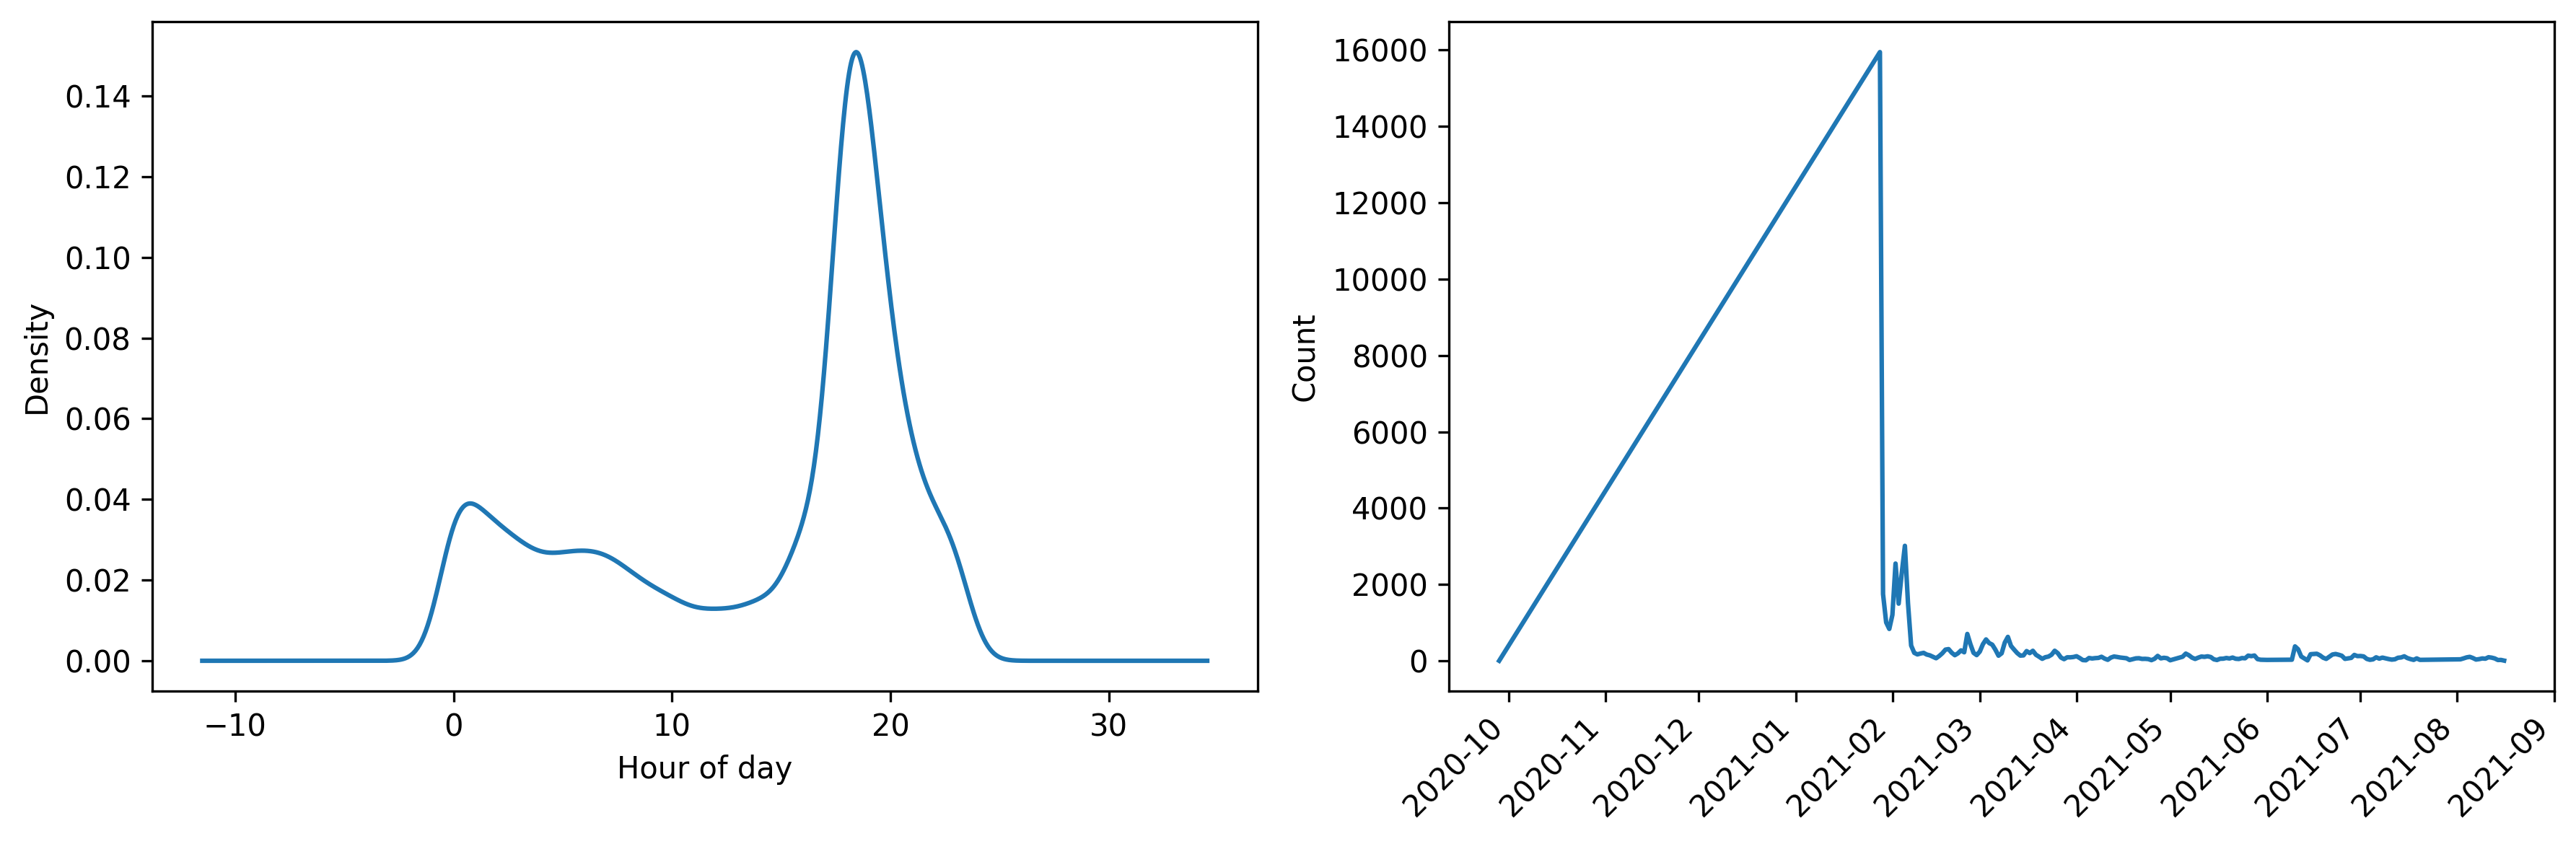

In [3]:
# check distribution of post creation
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
datetimes = pd.to_datetime(raw_posts['created'], unit='s', utc=True)
datetimes = datetimes.dt.tz_convert('America/New_York')
datetimes.dt.hour.plot(kind='density', ax=axes[0])
datetimes.dt.date.value_counts().plot(ax=axes[1])
axes[0].set_xlabel('Hour of day')
axes[1].set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

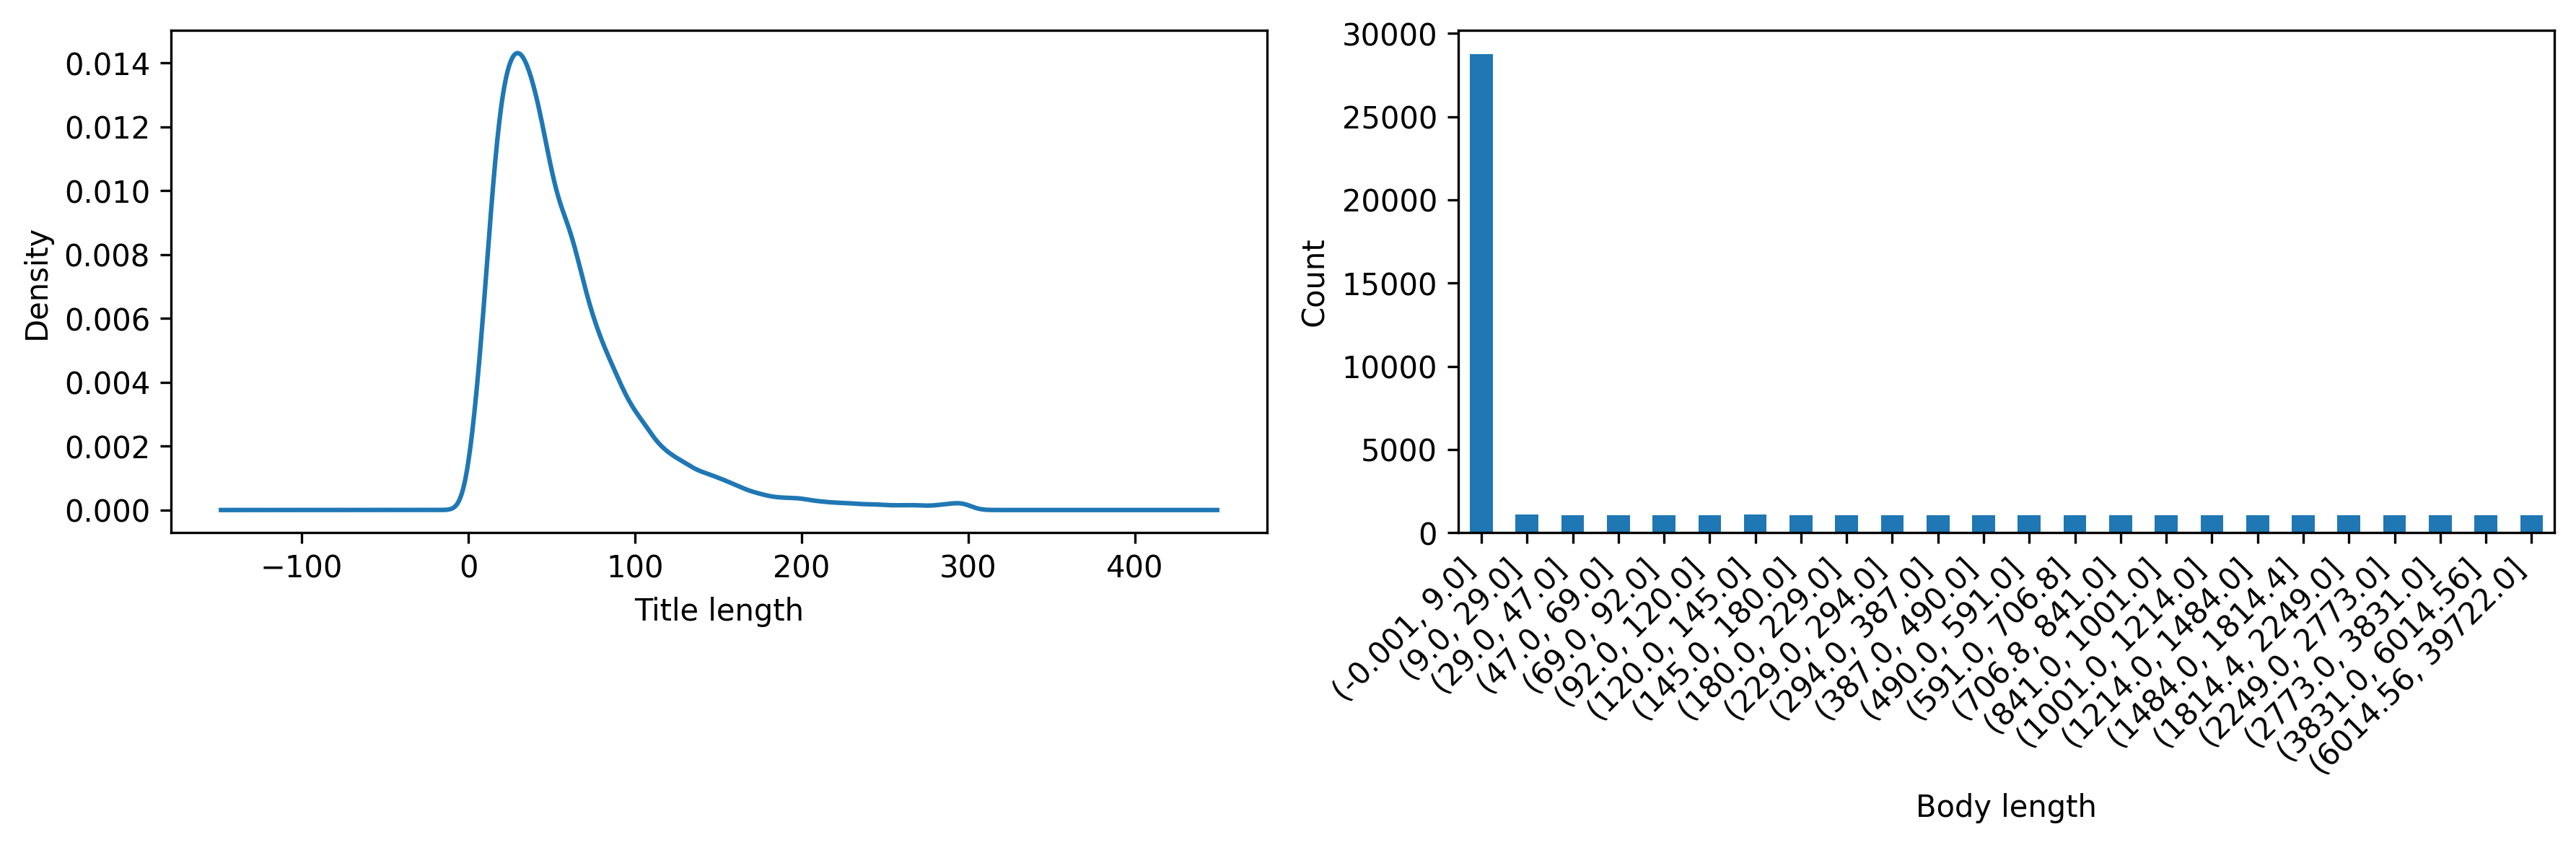

In [4]:
# check for length of post titles and bodies
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
raw_posts['title'].str.len().plot(kind='density', ax=axes[0])
bodies = pd.qcut(raw_posts['body'].fillna('').str.len(), 50, duplicates='drop').value_counts()
bodies.sort_index().plot(kind='bar', ax=axes[1])
axes[0].set_xlabel('Title length')
axes[1].set_xlabel('Body length')
axes[1].set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# check for html in post titles and bodies
combined = (raw_posts['title'] + ' ' + raw_posts['body'].fillna(''))
combined.str.findall(r'(<[a-zA-Z]+[^>]*?>)').explode().unique()

array([nan, '<STOCK-CODE>',
       "<Fuck! He's looking at the $90 and the $115 I sold, shit's embarrassing>",
       '<I paid $8500>', "<It's 9:55am and GME is at $440/share>",
       '<Confirms order, puts me on hold for a minute>',
       '<GME now at $460/share>', '<deep breath>', '<MAN/WOMAN>',
       '<NAME>', '<CITY/DISTRICT>',
       '<blockquote class="imgur-embed-pub" lang="en" data-id="a/FCWPeze" data-context="false" >',
       '<a href="\\\\\\[//imgur.com/a/FCWPeze\\\\\\](//imgur.com/a/FCWPeze)">',
       '<script async src="\\\\\\[//s.imgur.com/min/embed.js\\\\\\](//s.imgur.com/min/embed.js)" charset="utf-8">',
       '<strike price>',
       '<open following link in incognito for multiple visits>',
       '<Obligatory rocketship emoji>', '<Almost forget these...>',
       '<name>', '<insert target group here>',
       '<insert your favorite game developer/publisher>', '<sigh>',
       '<cough>', '<numberofshares>', '<average>', '<selllimit>', '<it>',
       '<a class="emb

# Preprocess Post Data

In [6]:
# create copy of raw
pre_posts = raw_posts.copy()

# concatenate into one text field
pre_posts['body'] = pre_posts['body'].fillna('')
pre_posts['fixed_text'] = pre_posts['title'] + ' ' + pre_posts['url'] + ' ' + pre_posts['body']

# remove reddit-related and youtube-related urls from title and body,
# as they are frequent and carry no semantic meaning
pattern = r'https?\:\/\/[^\/]*(redd\.?it|youtu\.?be)\S+'
pre_posts['fixed_text'] = pre_posts['fixed_text'].str.replace(pattern, ' ', regex=True)

# remove identified html tags, fix html entities and fix white space
pattern = r'<(a|script|blockquote)[^>]*?>'
pre_posts['fixed_text'] = pre_posts['fixed_text'].str.replace(pattern, ' ', flags=re.I, regex=True)
pre_posts['fixed_text'] = pre_posts['fixed_text'].apply(html.unescape)
pre_posts['fixed_text'] = pre_posts['fixed_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# exclude temporal outlier (single post in 2020)
pre_posts = pre_posts[pre_posts.index != 32591]

# correct UNIX timestamps that are 8 hours off from UTC before July 21st (manually confirmed)
def fix_utc(row):
    row['fixed_created'] = row['created'] - (60 * 60 * 8 if row['timestamp'] < '2021-07-21' else 0)
    return row

# apply
pre_posts = pre_posts.apply(fix_utc, axis=1)

# convert UNIX timestamp to NY timezone used by NYSE / NASDAQ
pre_posts['fixed_datetime'] = pd.to_datetime(pre_posts['fixed_created'], unit='s', utc=True)
pre_posts['fixed_datetime'] = pre_posts['fixed_datetime'].dt.tz_convert('America/New_York')

# Extract Stock Symbols

In [7]:
# get symbols preceded by $, e.g. $GME $GOOGL $SPY etc.
pattern = r'\$([a-zA-Z]{1,5}(?:[\.\-][a-zA-Z]{1,2})?)\b'
pre_posts['pre_symbols'] = [[str(s).upper().replace('-', '.') for s in m]
                            for m in pre_posts['fixed_text'].str.findall(pattern)]
pre_symbols = pre_posts['pre_symbols'].explode().value_counts()
pre_symbols

GME      2845
AMC       871
BB        642
NOK       436
RKT       345
         ... 
NI          1
BMV         1
GRBMF       1
CERAF       1
UHAL        1
Name: pre_symbols, Length: 1335, dtype: int64

In [8]:
# load spacy model
nlp = spacy.load('en_core_web_lg')

# expand symbols by NER classified as ORG or MONEY (without $)
def exp_symbols(row):
    doc = nlp(row['fixed_text'])
    row['exp_symbols'] = row['pre_symbols']
    row['exp_symbols'] += [s for e in doc.ents
                           if (s := str(e.text).replace('-', '.')) in pre_symbols
                           and e.label_ in ['ORG', 'MONEY']]
    return row

# update symbols
sym_posts = pre_posts.apply(exp_symbols, axis=1)
exp_symbols = sym_posts['exp_symbols'].explode().value_counts()
exp_symbols

GME       21805
AMC        7027
WSB        3321
BB         2540
PLTR       1653
          ...  
STNE          1
IIVI          1
TEAM          1
ADDF          1
FIZZ.Y        1
Name: exp_symbols, Length: 1335, dtype: int64

In [9]:
# determine main symbol per post from frequency (highest), order of appearance (first)
def main_symbol(symbols):
    counts = Counter(symbols).most_common(2)
    if len(counts) == 2 and counts[0][1] == counts[1][1]:
        return symbols[0]
    elif len(counts) == 1:
        return counts[0][0]
    return ''

# apply
sym_posts['main_symbol'] = sym_posts['exp_symbols'].apply(main_symbol)

# relevant main symbols occur in at least 10 posts
main_symbols = sym_posts['main_symbol'].value_counts()
main_symbols = main_symbols[(main_symbols.index != '') & (main_symbols >= 10)]
main_symbols

GME     8229
AMC     2084
WSB     1069
BB       585
PLTR     500
        ... 
GPRO      10
MARA      10
ARKK      10
INO       10
NAK       10
Name: main_symbol, Length: 109, dtype: int64

# Retrieve Price Data

In [10]:
# get historic daily price data for main symbols
for symbol, count in main_symbols.items():
    filename = work_dir('price_data', symbol + '.csv')
    if os.path.exists(filename):
        continue
    symbol = symbol.replace('.', '-') # yahoo finance uses - instead of .
    url = 'https://query1.finance.yahoo.com/v7/finance/download/{}?period1=1606780800&period2='
    url += '1633046400&interval=1d&events=history&includeAdjustedClose=true'.format(symbol)
    try:
        pd.read_csv(url).to_csv(filename)
    except:
        pass

# valid symbols are main symbols that were recognized by yahoo
valid_symbols = [s[:-4] for s in os.listdir(work_dir('price_data'))]
sym_posts['valid_symbol'] = sym_posts.apply(
    lambda x: x['main_symbol'] if x['main_symbol'] in valid_symbols else ''
, axis=1)
print(sym_posts.loc[sym_posts['valid_symbol'] != '', 'valid_symbol'].value_counts())

GME     8229
AMC     2084
BB       585
PLTR     500
NOK      268
        ... 
MARA      10
ARKK      10
JPM       10
INO       10
GPRO      10
Name: valid_symbol, Length: 93, dtype: int64


# Sentiment Analysis

In [11]:
# init vader analyzer
analyzer = SentimentIntensityAnalyzer()

# copy posts
sen_posts = sym_posts.copy()

# use vader compound as sentiment score
sen_posts['raw_sentiment'] = sen_posts['fixed_text'].apply(analyzer.polarity_scores)
sen_posts['raw_sentiment'] = sen_posts['raw_sentiment'].apply(lambda x: x['compound'])

# collapse sentiments into neg/non-neg
sen_posts['sentiment'] = np.where(sen_posts['raw_sentiment'] < 0, -1, 1)
sen_posts['sentiment'].value_counts()

 1    39083
-1    14103
Name: sentiment, dtype: int64

# Preprocess Price Data

In [12]:
# get all prices for valid symbols
prices = pd.concat([
    pd.concat([
        (df := pd.read_csv(work_dir('price_data', symbol + '.csv'))),
        pd.DataFrame({'Symbol': [symbol]}, index=df.index)
    ], axis=1) for symbol in valid_symbols
], ignore_index=True)

# exclude noise column, convert to datetime object, sort values
prices = prices.iloc[:, 1:]
prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.sort_values('Date')

# per-symbol emas for backward/forward abs log price change, log price change, log volume change
def emas(group, span=20):
    group['-%sP' % span] = (np.log(group['Close']).diff(1)).ewm(span=span).mean()
    group['-%sV' % span] = (np.log(group['Volume']).diff(1)).ewm(span=span).mean()
    group['+%sV' % span] = (np.log(group['Volume']).diff(-1) *-1)[::-1].ewm(span=span).mean()[::-1]
    group['+%sP' % span] = (np.log(group['Close']).diff(-1) * -1)[::-1].ewm(span=span).mean()[::-1]
    return group

# apply emas
prices = prices.groupby('Symbol', group_keys=False).apply(emas)

# inspect GME right before squeeze
prices[(prices['Symbol'] == 'GME') & (prices['Date'] > '2021-01-24')].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,-20P,-20V,+20V,+20P
36,2021-01-25,24.182501,39.794998,15.282500,19.197500,19.197500,711496000,GME,0.100138,0.187054,-0.130626,0.037946
37,2021-01-26,22.139999,37.500000,20.049999,36.994999,36.994999,714352000,GME,0.154416,0.169180,-0.144797,-0.027112
38,2021-01-27,88.707497,95.000000,62.250000,86.877502,86.877502,373586800,GME,0.222535,0.089556,-0.091805,-0.119831
39,2021-01-28,66.250000,120.750000,28.062500,48.400002,48.400002,235263200,GME,0.144043,0.035902,-0.052790,-0.070866
40,2021-01-29,94.927498,103.495003,62.500000,81.250000,81.250000,202264400,GME,0.180323,0.017758,-0.042439,-0.132855


# Prices to Posts Mapping

In [13]:
# conservative mapping to price date for testing price as leading indicator
# (use previous close, even if user might be affected by movements from open market)
def backward_date(dt):
    offset = int(dt.hour < 16)
    return pd.to_datetime((dt - pd.Timedelta(days=offset)).date())

# conservative mapping to price date for testing sentiment as leading indicator
# (use previous days close unless market opened, then use today)
def forward_date(dt):
    offset = int(dt.hour < 9 or (dt.hour == 9 and dt.minute < 30))
    return pd.to_datetime((dt - pd.Timedelta(days=offset)).date())

# post copy
map_posts = sen_posts.copy()

# apply
map_posts['backward_date'] = map_posts['fixed_datetime'].apply(backward_date)
map_posts['forward_date'] = map_posts['fixed_datetime'].apply(forward_date)

# locate valid trading backward date
map_posts.sort_values('backward_date', inplace=True)
map_posts = pd.merge_asof(map_posts,
                          prices[['Date', 'Symbol']],
                          left_on='backward_date',
                          right_on='Date',
                          left_by='valid_symbol',
                          right_by='Symbol',
                          suffixes=('-', '+'),
                          direction='backward')

# locate valid trading forward date
map_posts.sort_values('forward_date', inplace=True)
map_posts = pd.merge_asof(map_posts,
                          prices[['Date', 'Symbol']],
                          left_on='forward_date',
                          right_on='Date',
                          left_by='valid_symbol',
                          right_by='Symbol',
                          suffixes=('-', '+'),
                          direction='backward') # no mistake, should look backward for forward date

# combine (+) for leading indicator, (-) for trailing indicator
posts = pd.concat([
    map_posts.rename(columns={'Date+': 'date'}).groupby(['valid_symbol', 'date'])['sentiment'].sum().rename('+sentiment'),
    map_posts.rename(columns={'Date-': 'date'}).groupby(['valid_symbol', 'date'])['sentiment'].sum().rename('-sentiment')
], axis=1).reset_index()

# filter out posts without symbols and sort by date
posts = posts[posts['valid_symbol'] != ''].sort_values('date')

# finally concatenate
final = pd.concat([
    prices.set_index(['Symbol', 'Date']),
    posts.rename(columns={'valid_symbol': 'Symbol', 'date': 'Date'}).set_index(['Symbol', 'Date'])
], axis=1).reset_index()

# check
final[~final['-sentiment'].isna() | ~final['+sentiment'].isna()]

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,-20P,-20V,+20V,+20P,+sentiment,-sentiment
3359,AAPL,2021-01-27,143.429993,144.300003,140.410004,142.059998,139.416718,140843800,0.006410,0.025029,-0.032429,-0.006720,NaN,1.0
3360,SKT,2021-01-27,16.990000,20.959999,16.540001,17.860001,15.427073,27156600,0.037403,0.185498,-0.175626,-0.018681,NaN,1.0
3362,BABA,2021-01-27,265.130005,265.920013,259.950012,260.250000,256.797943,16050400,0.004312,-0.037266,-0.005415,-0.000813,1.0,2.0
3364,BB,2021-01-27,20.250000,28.770000,19.809999,25.100000,25.100000,372222600,0.086350,0.191688,-0.206452,-0.066870,3.0,68.0
3365,IBKR,2021-01-27,64.570000,64.989998,62.849998,63.130001,62.035770,1556600,-0.004349,0.059212,-0.037391,0.009721,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16037,UWMC,2021-08-13,7.620000,7.940000,7.510000,7.860000,6.415217,6313600,0.002514,0.098781,-0.078269,-0.007374,2.0,2.0
16045,HOOD,2021-08-13,48.450001,53.200001,48.220001,50.630001,50.630001,25659800,0.019410,-0.096924,-0.094714,-0.011102,1.0,NaN
16051,DIS,2021-08-13,186.289993,187.580002,180.880005,181.080002,180.491760,32504600,0.002138,0.146570,-0.145267,-0.001702,2.0,2.0
16057,UPST,2021-08-13,187.815002,205.190002,184.500000,203.289993,203.289993,14229600,0.039630,0.114638,-0.095349,0.010626,0.0,1.0


# Stock Symbol Interactions

In [14]:
# significance filtered spearman's rank correlation
def sigcorr(df, alpha=.05):
    corrs = pd.DataFrame(np.NaN, index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                continue # skip identical columns
            nonan = df[~df[col1].isna() & ~df[col2].isna()]
            if nonan[col1].nunique() <= 1 or nonan[col2].nunique() <= 1:
                continue # skip constant columns
            r, p = spearmanr(nonan[col1], nonan[col2])
            if p >= alpha:
                continue # skip non significant
            corrs.loc[col1, col2] = r
    return corrs

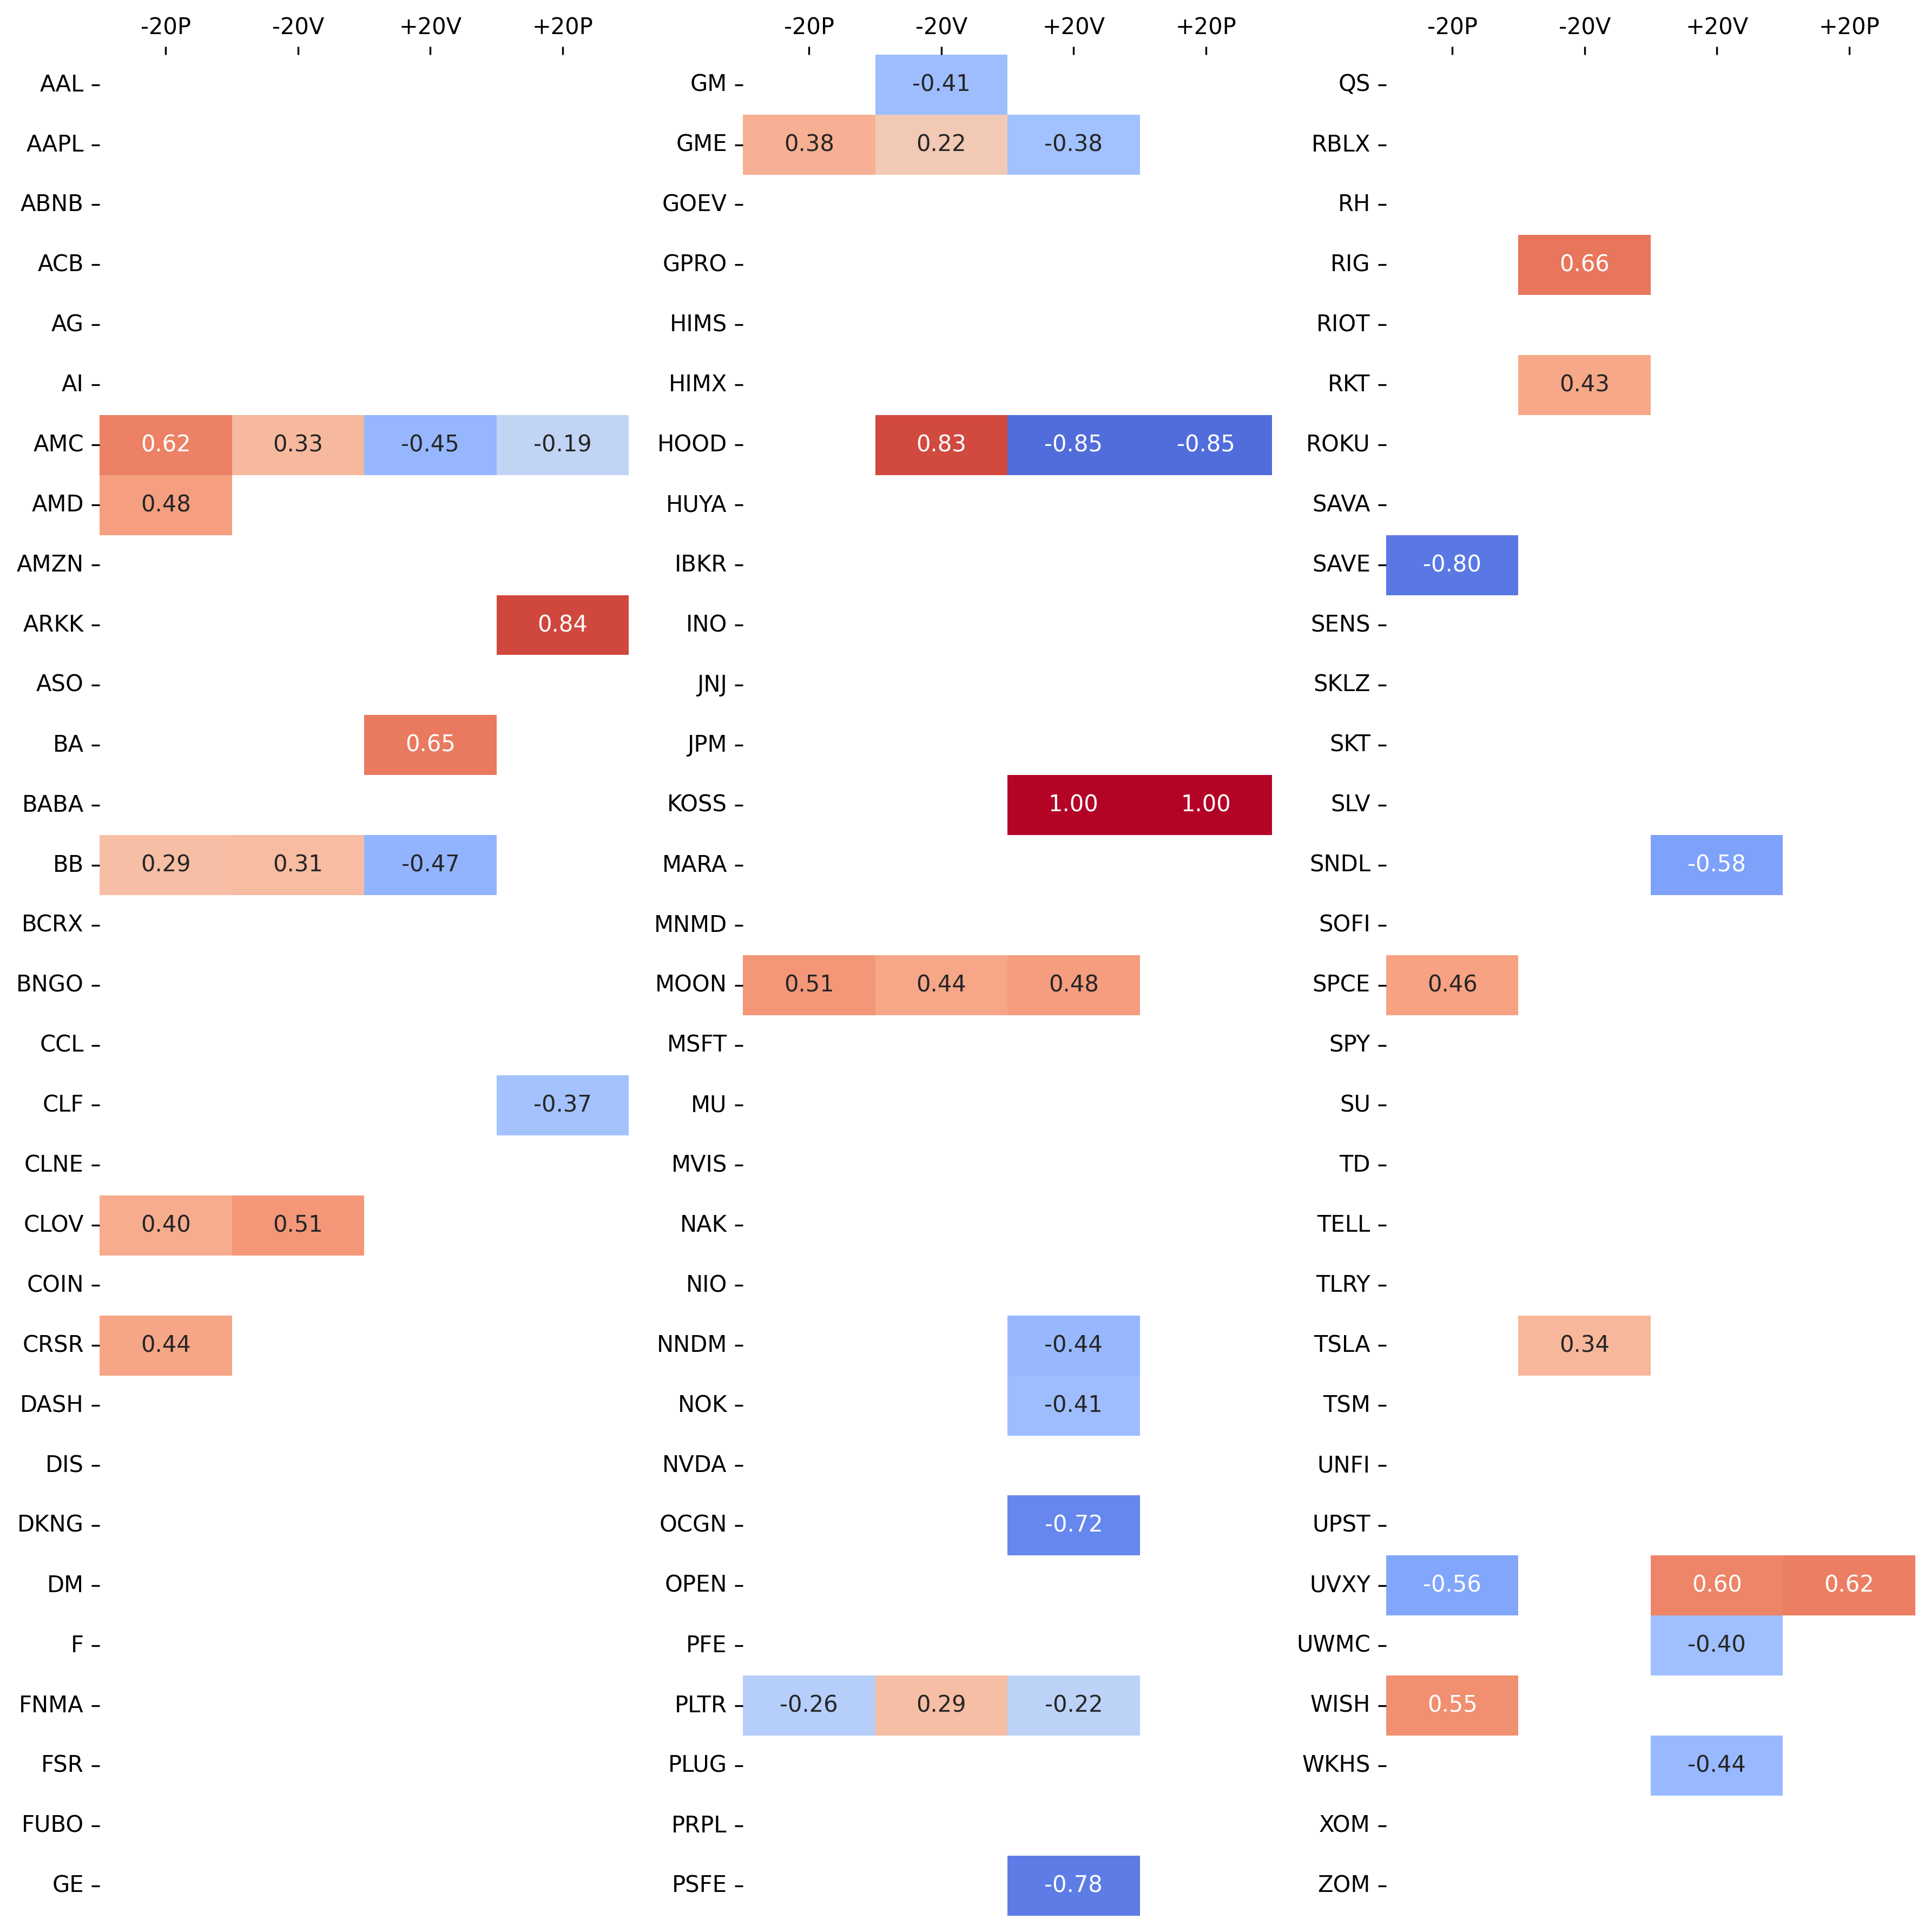

In [15]:
# symbol specific correlation
trailings = ['-20P', '-20V', '-sentiment']
leadings = ['+20V', '+20P', '+sentiment']

# spearmans rank per symbol, abs for backward
b = final.groupby('Symbol')[trailings].apply(lambda g: sigcorr(g))
f = final.groupby('Symbol')[leadings].apply(lambda g: sigcorr(g))

# concatenate backward/forward sentiment correlations (not posts)
c = pd.concat([
    b.xs(key=trailings[2], level=1, axis=0)[trailings[:2]],
    f.xs(key=leadings[2], level=1, axis=0)[leadings[:2]]
], axis=1)

# plot triplet heatmap (of sentiment)
fig, axes = plt.subplots(1, 3, figsize=(12, 12), dpi=300)
for i, ax in enumerate(axes):
    u = len(c) // 3
    sns.heatmap(c.iloc[u * i:u * (i + 1)], annot=True, fmt='.2f',
                ax=ax, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
    ax.xaxis.tick_top()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Overall Market Interactions

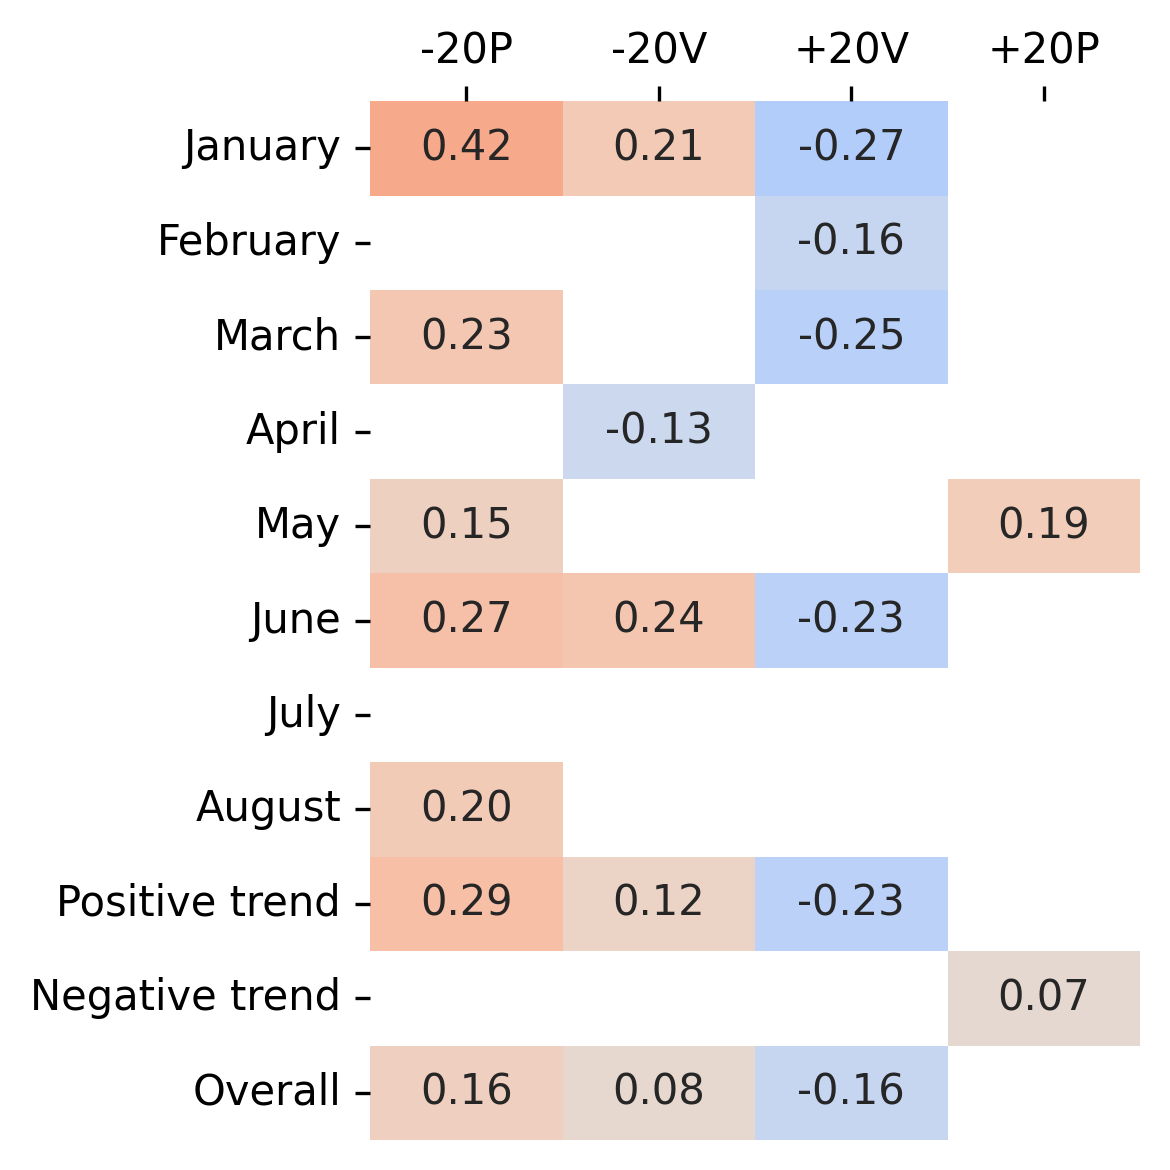

In [16]:
# correlation analysis across symbols
trailings = ['-20P', '-20V', '-sentiment']
leadings = ['+20V', '+20P', '+sentiment']

# conditions for segmentation
segments = {'January': final['Date'].dt.month == 1,
            'February': final['Date'].dt.month == 2,
            'March': final['Date'].dt.month == 3,
            'April': final['Date'].dt.month == 4,
            'May': final['Date'].dt.month == 5,
            'June': final['Date'].dt.month == 6,
            'July': final['Date'].dt.month == 7,
            'August': final['Date'].dt.month == 8,
            'Positive trend': (final['-20P'] > 0),
            'Negative trend': (final['-20P'] < 0),
            'Overall': final.index > -1}

# gather
c = pd.concat([
    pd.concat([
        sigcorr(final.loc[condition, trailings]).loc[trailings[2], trailings[:2]].rename(segment),
        sigcorr(final.loc[condition, leadings]).loc[leadings[2], leadings[:2]].rename(segment)
    ])
    for segment, condition in segments.items()
], axis=1).T

# plot heatmap (of sentiment)
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
sns.heatmap(c, annot=True, fmt='.2f', ax=ax, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_ylabel('')
plt.tight_layout()
plt.show()